In [3]:
# 데이터 처리 및 수치 계산
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 및 그래프 설정
plt.rcParams["font.family"] = 'NanumGothic'     
mpl.rcParams["axes.unicode_minus"] = False     

# 경고 제거
import warnings
warnings.filterwarnings('ignore')

# 통계 분석
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 머신러닝 - 전처리, 모델링, 평가
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# 기타 설정
random_state = 42

# Jupyter에서 그래프 바로 출력
%matplotlib inline


In [4]:
df_raw = pd.read_csv('/home/piai/바탕화면/posco-academy-30th/big_data_class/01 실습파일/2. Big Data 분석/Car.csv', encoding='euc-kr')
df_raw.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


In [5]:
# price 컬럼의 결측치 제거
df_raw_price = df_raw[~df_raw['Price'].isnull()]

In [6]:
df_raw_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 0 to 7236
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6200 non-null   object 
 1   Location           6200 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               6200 non-null   int64  
 4   Kilometers_Driven  6200 non-null   int64  
 5   Fuel_Type          6200 non-null   object 
 6   Transmission       6200 non-null   object 
 7   Owner_Type         6200 non-null   object 
 8   Mileage            6198 non-null   object 
 9   Engine             6164 non-null   object 
 10  Power              6164 non-null   object 
 11  Seats              6158 non-null   float64
 12  New_Price          1005 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 678.1+ KB


In [7]:
# Name : 자동차 메인 브랜드만 추출
df_raw_price['Brand'] = df_raw_price['Name'].str.split(' ').str[0]

# Year : 데이터 수집이 2019년(max)이라고 가정하고 몇년됐는지?
df_raw_price['For_year'] = max(df_raw_price['Year']) - df_raw_price['Year']

# Mileage : 연비 : 문자열로 돼있음 + 연비가 0으로 돼있는게 있다.(68개) -> 이거를 결측치로 봐야할듯함.
df_raw_price['Mileage_num']=df_raw_price['Mileage'].str.split(' ').str[0].astype(float)

# Engine :  문자열로 돼있음 -> 전기차가 배기량이 77임....전기차는 거르는게 맞나요?? 안거를려고 했는데.....일단 기다려보자
df_raw_price['Engine_num']=df_raw_price['Engine'].str.split(' ').str[0].astype(float)

# Power
df_raw_price['Power_num'] = (df_raw_price['Power'].str.split(' ').str[0].replace('null', np.nan) .astype(float))

# new price 일단 드랍 할게요~
df_raw_price = df_raw_price.drop(columns=['New_Price'])

# 결측값 싹 다 지워~~~
df_raw_price.dropna(inplace=True)

In [8]:
df_raw_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6053 entries, 0 to 7236
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6053 non-null   object 
 1   Location           6053 non-null   object 
 2   Price              6053 non-null   float64
 3   Year               6053 non-null   int64  
 4   Kilometers_Driven  6053 non-null   int64  
 5   Fuel_Type          6053 non-null   object 
 6   Transmission       6053 non-null   object 
 7   Owner_Type         6053 non-null   object 
 8   Mileage            6053 non-null   object 
 9   Engine             6053 non-null   object 
 10  Power              6053 non-null   object 
 11  Seats              6053 non-null   float64
 12  Brand              6053 non-null   object 
 13  For_year           6053 non-null   int64  
 14  Mileage_num        6053 non-null   float64
 15  Engine_num         6053 non-null   float64
 16  Power_num          6053 

In [9]:
# 준규형이랑 합치기 전에 column명 통일하기!!!

def make_new_parameter(df):
# 사전 변수들 만들기
    # 차량 브랜드
    df['Brand'] = df['Name'].str.split(' ').str[0]
    # 차량 연식
    df['car_age'] = max(df['Year']) - df['Year']
    # 차량 주행거리
    if df['Mileage'].dtype == 'object':
        df['Mileage'] = df['Mileage'].str.split(' ').str[0].astype(float)
    # 차량 배기량
    if df['Engine'].dtype == 'object':
        df['Engine'] = df['Engine'].str.split(' ').str[0].astype(float)
    # 차량 파워
    if df['Power'].dtype == 'object':
        df['Power'] = df['Power'].str.split(' ').str[0].replace('null', np.nan).astype(float)
    # Owner type
    df['Owner_Type'] = df['Owner_Type'].replace({'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 4})

    # 1. Power / Engine (연료 대비 파워) : Power_per_Engine
    df['Power_per_Engine'] = df['Power'] / df['Engine']

    # 2.Kilometers_Driven/car age (연식 대비 주행거리) : Mileage_per_car_age
    df['Mileage_per_car_age'] = df['Mileage'] / df['car_age']

    # 3. Kilometers_Driven/Owner_Type (차량 소유자 유형 대비 주행거리) : Kilometers_Driven_Owner_Type
    df['Kilometers_Driven_Owner_Type'] = df['Kilometers_Driven'] / df['Owner_Type']

    # 4. car_age/Owner_Type (차량 소유자 유형 대비 연식) : car_age_Owner_Type
    df['car_age_Owner_Type'] = df['car_age'] / df['Owner_Type']

    # 5. 1번 변수 범주화 해야함.....

    # 6. 도시 범주화 해야함.

    # 7. 연간가치 하락률

    # 8. new_price만 할 수 있는 범주화

    # 9. 차 브랜드 범주화

    # 10. Power / Seats (파워 대비 좌석수) : Power_per_Seats
    df['Power_per_Seats'] = df['Power'] / df['Seats']

    return df


In [10]:
df_new = make_new_parameter(df_raw_price)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6053 entries, 0 to 7236
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          6053 non-null   object 
 1   Location                      6053 non-null   object 
 2   Price                         6053 non-null   float64
 3   Year                          6053 non-null   int64  
 4   Kilometers_Driven             6053 non-null   int64  
 5   Fuel_Type                     6053 non-null   object 
 6   Transmission                  6053 non-null   object 
 7   Owner_Type                    6053 non-null   int64  
 8   Mileage                       6053 non-null   float64
 9   Engine                        6053 non-null   float64
 10  Power                         6053 non-null   float64
 11  Seats                         6053 non-null   float64
 12  Brand                         6053 non-null   object 
 13  For

<Axes: xlabel='Power_per_Engine', ylabel='Count'>

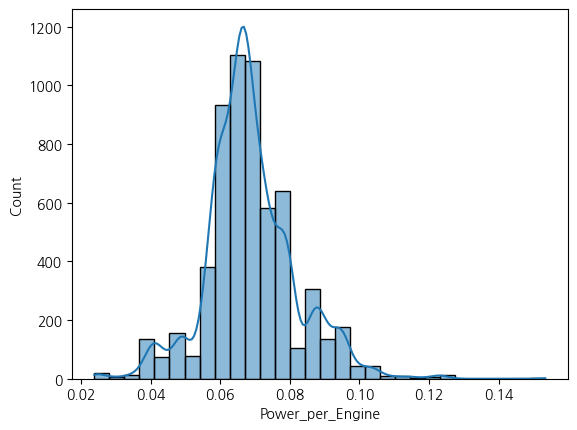

In [11]:
sns.histplot(df_new['Power_per_Engine'], bins=30, kde=True)
# df_new['Power_per_Engine'] 이거를 범주화도 시키고 싶은데 어떤거 기준으로 하면 될까?


In [ ]:
# Power_per_Engine을 4분위수로 범주화
df_new['Power_per_Engine_Q4'] = pd.qcut(df_new['Power_per_Engine'], 
                                        q=4, 
                                        labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# 결과 확인
print("=== Power_per_Engine 4분위수 범주화 결과 ===")
print(df_new['Power_per_Engine_Q4'].value_counts().sort_index())

# 각 그룹의 기본 통계량
print("\n=== 각 그룹별 Power_per_Engine 통계량 ===")
print(df_new.groupby('Power_per_Engine_Q4')['Power_per_Engine'].describe())